In [16]:
# Import of relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression

In [17]:
def prepForModel(df):
    drop_cols = [
        'blurb',
        'creator',
        'currency',
        'currency_trailing_code',
        'fx_rate',
        'location',
        'name',
        'profile',
        'slug',
        'source_url',
        'static_usd_rate',
        'usd_type',
        'spotlight'
    ]
    df.drop(drop_cols, inplace=True, axis = 1)
    for c in df.columns: 
        if df[c].dtype == "object": 
            df[c] = df[c].astype("category") 
    df.dropna(inplace=True)
    return df

In [18]:
df = pd.read_csv('data/df_clean.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [19]:
df = prepForModel(df)

### Create new timestamp features

In [20]:
df['delta_create_deadline'] = df['deadline'] - df['created_at']
df['delta_create_launch'] = df['launched_at'] - df['created_at']
df['delta_create_change'] = df['state_changed_at'] - df['created_at']
df['delta_launch_deadline'] = df['deadline'] - df['launched_at']
df['delta_change_launch'] = df['state_changed_at'] - df['launched_at']
df['delta_deadline_change'] = df['deadline'] - df['launched_at']

In [21]:
df.head()

backers_count  converted_pledged_amount country  created_at    deadline  \
0              2                         2      CA  1540305218  1542900780   
1              2                         2      US  1462569183  1471994797   
2            119                      5635      US  1483369959  1487595600   
3             70                      1317      US  1325637522  1331530353   
4             73                      5134      US  1301344770  1306558117   

   disable_communication     goal  is_starrable  launched_at  pledged  ...  \
0                  False  30000.0         False   1540308166     3.29  ...   
1                  False  70000.0         False   1468106797     2.00  ...   
2                  False   4000.0         False   1486386355  5635.00  ...   
3                  False    500.0         False   1329719553  1317.69  ...   
4                  False   5000.0         False   1303102117  5134.01  ...   

   usd_pledged   category_name          category_slug  cgrouped  \
0     2.513164             Web         journalism/web        CA   
1     2.000000           Drama     film & video/drama        US   
2  5635.000000     Restaurants       food/restaurants        US   
3  1317.690000  Graphic Design  design/graphic design        US   
4  5134.010000          Poetry      publishing/poetry        US   

  delta_create_deadline delta_create_launch delta_create_change  \
0               2595562                2948             2595562   
1               9425614             5537614             9425614   
2               4225641             3016396             4225641   
3               5892831             4082031             5892831   
4               5213347             1757347             5213347   

   delta_launch_deadline  delta_change_launch  delta_deadline_change  
0                2592614              2592614                2592614  
1                3888000              3888000                3888000  
2                1209245              1209245                1209245  
3                1810800              1810800                1810800  
4                3456000              3456000                3456000  

[5 rows x 23 columns]

In [22]:
df.drop(columns=['created_at','deadline','launched_at','state_changed_at','country','category_name','cgrouped'], axis=1, inplace=True)

In [23]:
df.head()

backers_count  converted_pledged_amount  disable_communication     goal  \
0              2                         2                  False  30000.0   
1              2                         2                  False  70000.0   
2            119                      5635                  False   4000.0   
3             70                      1317                  False    500.0   
4             73                      5134                  False   5000.0   

   is_starrable  pledged  staff_pick       state  usd_pledged  \
0         False     3.29       False      failed     2.513164   
1         False     2.00       False      failed     2.000000   
2         False  5635.00       False  successful  5635.000000   
3         False  1317.69       False  successful  1317.690000   
4         False  5134.01       False  successful  5134.010000   

           category_slug  delta_create_deadline  delta_create_launch  \
0         journalism/web                2595562                 2948   
1     film & video/drama                9425614              5537614   
2       food/restaurants                4225641              3016396   
3  design/graphic design                5892831              4082031   
4      publishing/poetry                5213347              1757347   

   delta_create_change  delta_launch_deadline  delta_change_launch  \
0              2595562                2592614              2592614   
1              9425614                3888000              3888000   
2              4225641                1209245              1209245   
3              5892831                1810800              1810800   
4              5213347                3456000              3456000   

   delta_deadline_change  
0                2592614  
1                3888000  
2                1209245  
3                1810800  
4                3456000

In [101]:
df.describe()

backers_count  converted_pledged_amount          goal       pledged  \
count  187660.000000              1.876600e+05  1.876600e+05  1.876600e+05   
mean      145.083422              1.287253e+04  4.925061e+04  1.855209e+04   
std       891.369660              8.890722e+04  1.183795e+06  3.126225e+05   
min         0.000000              0.000000e+00  1.000000e-02  0.000000e+00   
25%         4.000000              1.060000e+02  1.500000e+03  1.080000e+02   
50%        27.000000              1.535000e+03  5.000000e+03  1.555000e+03   
75%        89.000000              6.546000e+03  1.500000e+04  6.897000e+03   
max    105857.000000              7.211620e+06  1.000000e+08  8.103074e+07   

        usd_pledged  delta_create_deadline  delta_create_launch  \
count  1.876600e+05           1.876600e+05         1.876600e+05   
mean   1.288387e+04           6.937509e+06         4.113044e+06   
std    8.898296e+04           1.141976e+07         1.135064e+07   
min    0.000000e+00           8.853300e+04         1.430000e+02   
25%    1.060000e+02           2.854760e+06         2.543972e+05   
50%    1.535000e+03           4.060798e+06         9.699930e+05   
75%    6.550418e+03           6.296492e+06         3.171754e+06   
max    7.211620e+06           2.880206e+08         2.854286e+08   

       delta_create_change  delta_launch_deadline  delta_change_launch  \
count         1.876600e+05           1.876600e+05         1.876600e+05   
mean          6.747548e+06           2.824465e+06         2.634503e+06   
std           1.143278e+07           1.018434e+06         1.149237e+06   
min           1.950000e+02           8.640000e+04         0.000000e+00   
25%           2.763116e+06           2.588400e+06         2.405462e+06   
50%           3.911476e+06           2.592000e+06         2.592000e+06   
75%           6.166699e+06           2.986028e+06         2.798632e+06   
max           2.880206e+08           8.044324e+06         8.044324e+06   

       delta_deadline_change  
count           1.876600e+05  
mean            2.824465e+06  
std             1.018434e+06  
min             8.640000e+04  
25%             2.588400e+06  
50%             2.592000e+06  
75%             2.986028e+06  
max             8.044324e+06

/Users/juliusjenek/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/juliusjenek/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/juliusjenek/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/juliusjenek/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/juliusjenek/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/juliusje

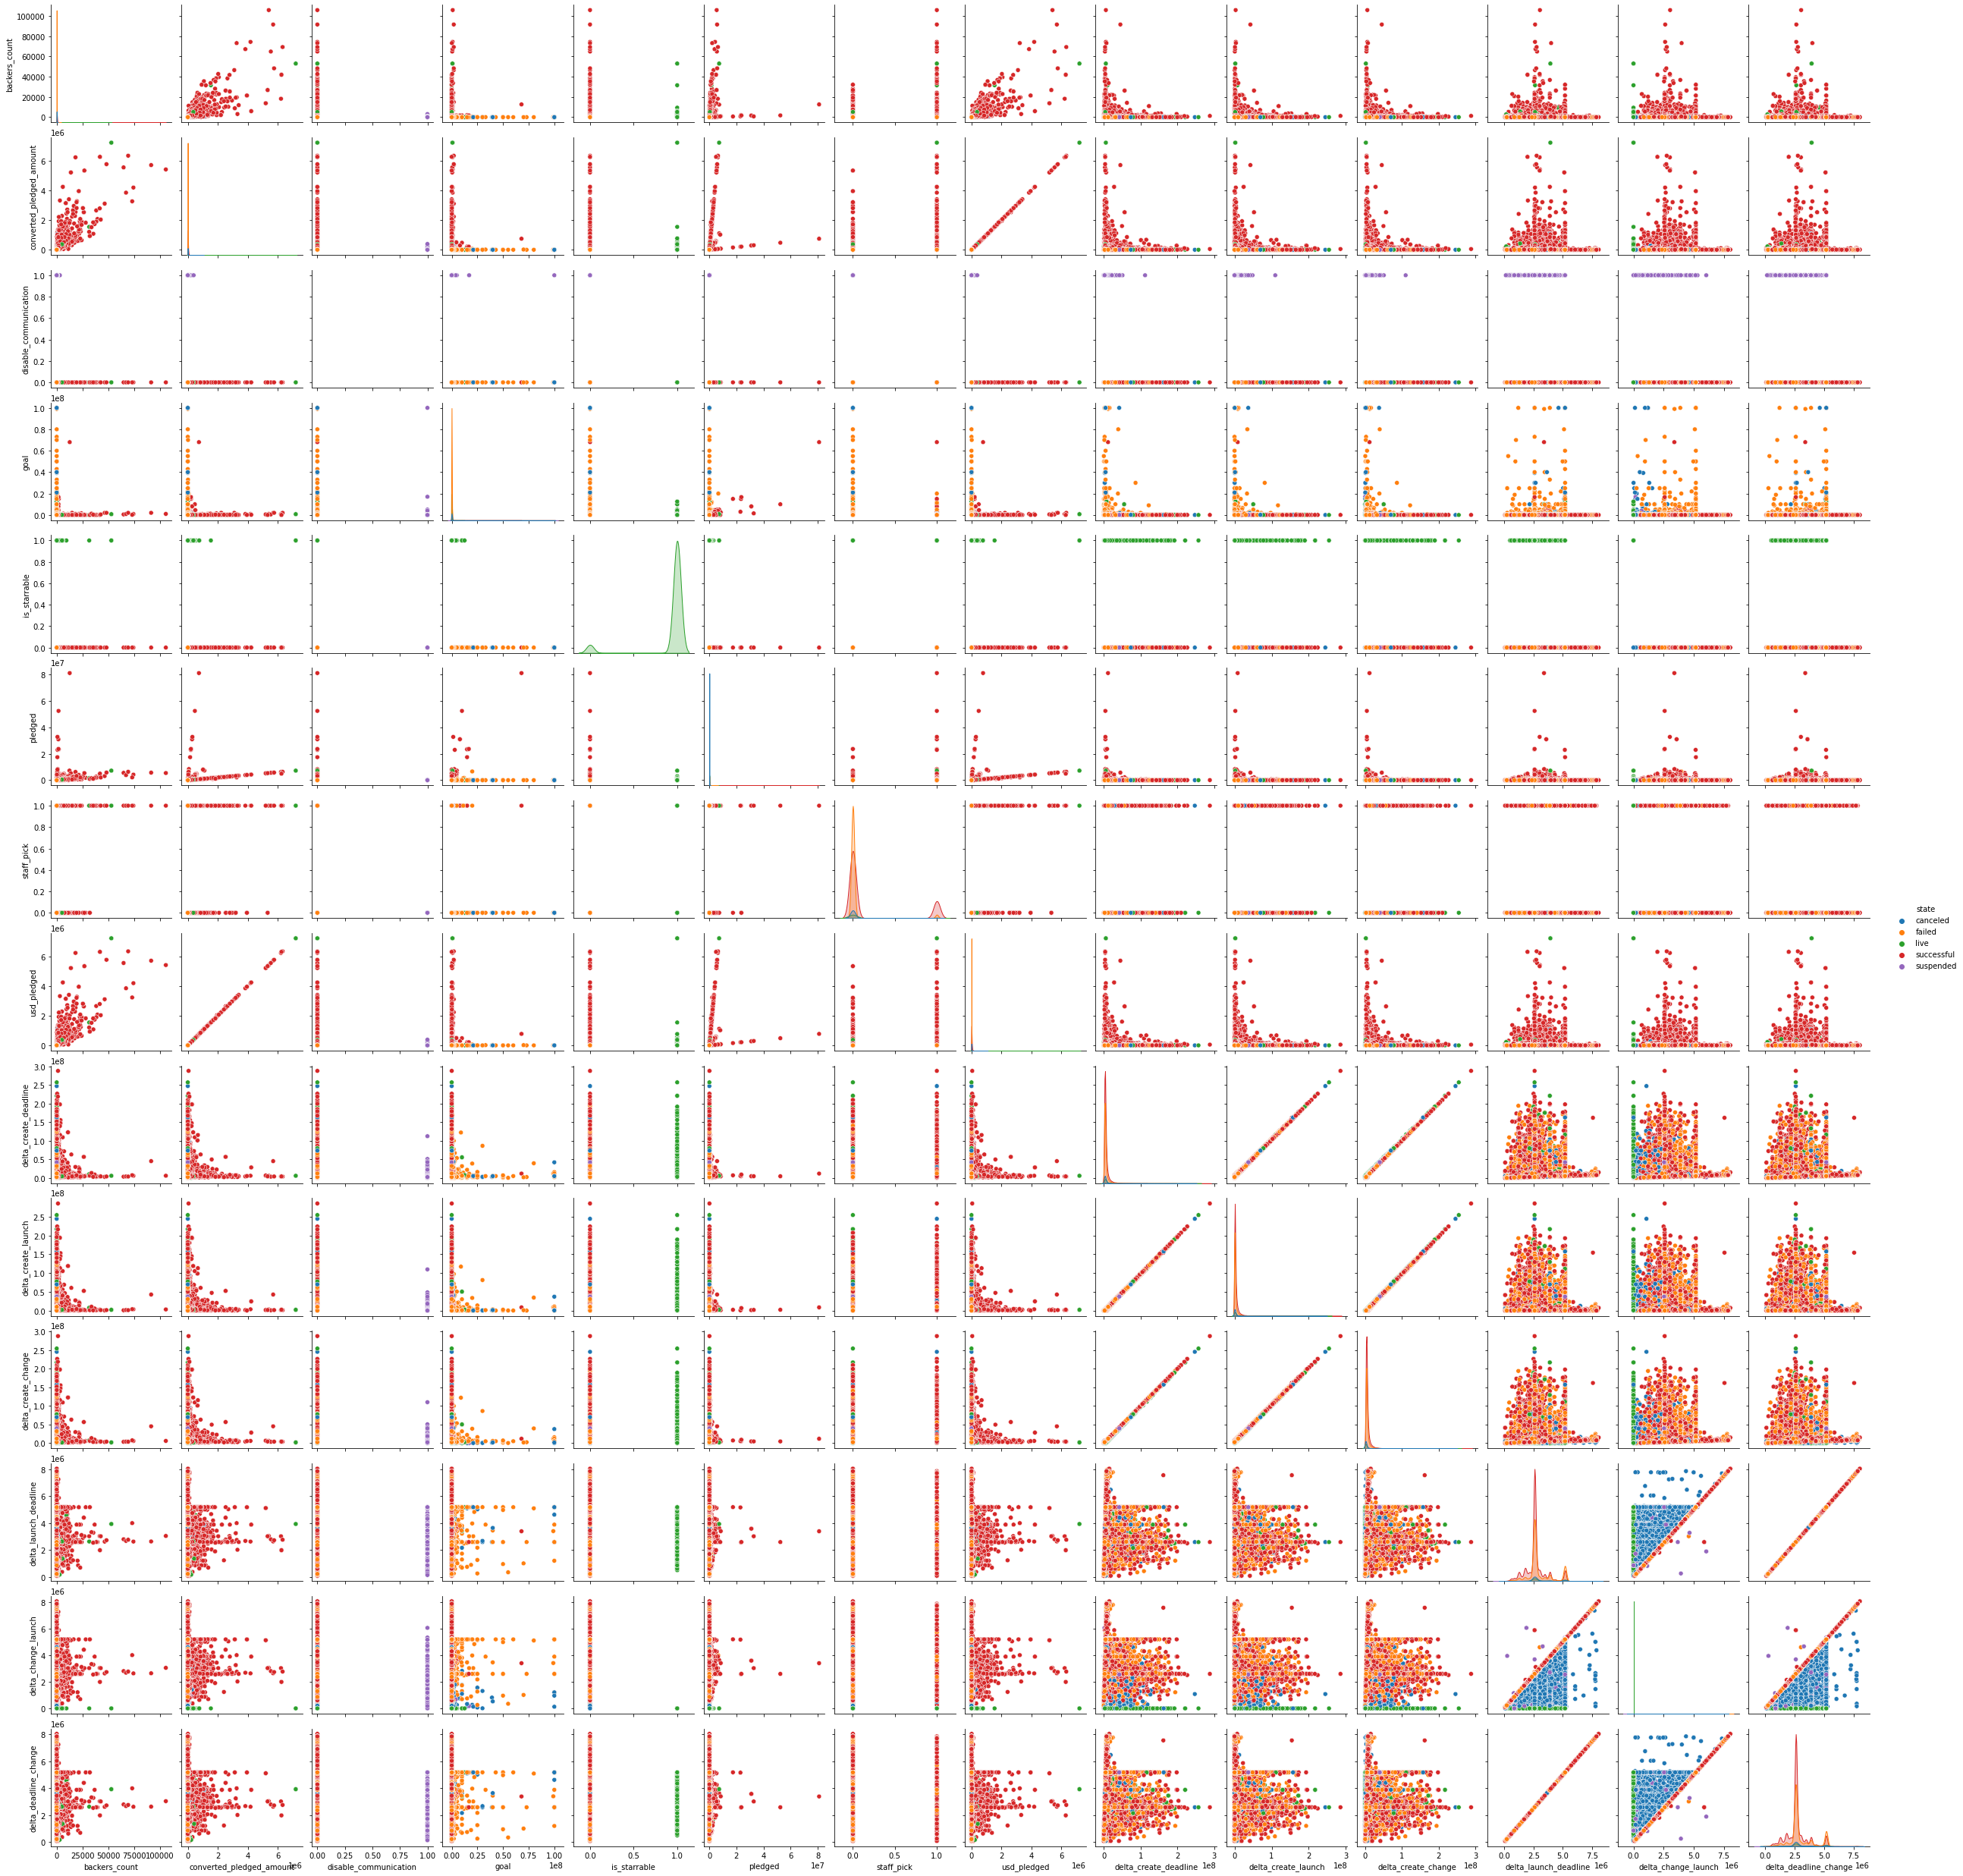

In [26]:
sns.pairplot(df, hue='state')

have a deeper look at following time feature correlation:
* all deltas - disable_communication (suspended vs other states)
* all deltas - goal (successful vs other states)
* delta_change_launch - is_starrable
* all deltas - backers_count
* all deltas - converted_pledged_amount

<AxesSubplot:xlabel='disable_communication', ylabel='count'>

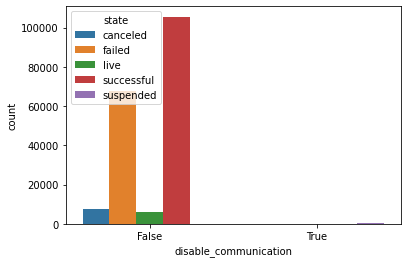

In [99]:
sns.countplot(x=df.disable_communication, hue=df.state)

<Figure size 1080x720 with 0 Axes>

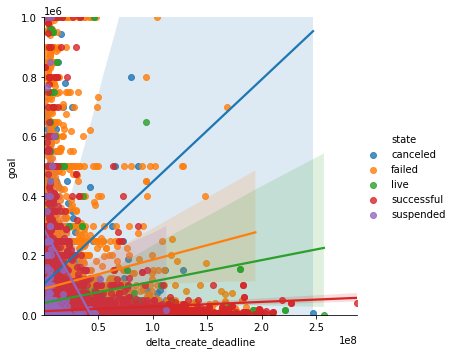

In [118]:
plt.figure(figsize=(15,10))
sns.lmplot(data=df, x='delta_create_deadline', y='goal', hue='state')
plt.ylim(0,1e6);

<Figure size 1080x720 with 0 Axes>

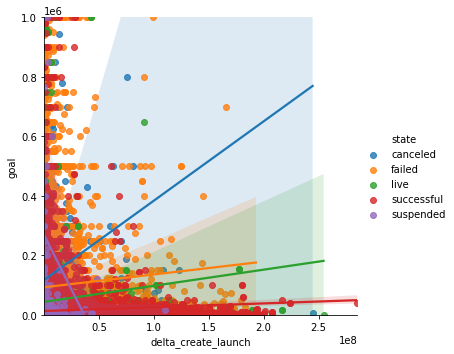

In [111]:
plt.figure(figsize=(15,10))
sns.lmplot(data=df, x='delta_create_launch', y='goal', hue='state')
plt.ylim(0,1e6);

<Figure size 1080x720 with 0 Axes>

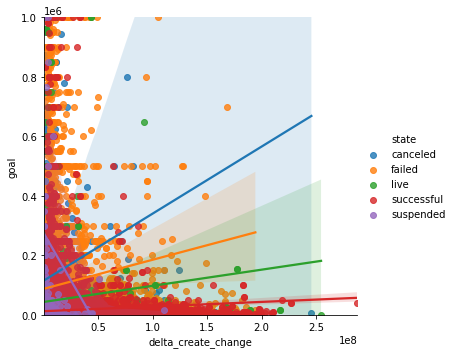

In [112]:
plt.figure(figsize=(15,10))
sns.lmplot(data=df, x='delta_create_change', y='goal', hue='state')
plt.ylim(0,1e6);

<Figure size 1080x720 with 0 Axes>

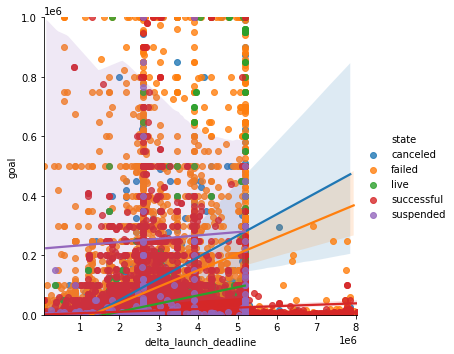

In [113]:
plt.figure(figsize=(15,10))
sns.lmplot(data=df, x='delta_launch_deadline', y='goal', hue='state')
plt.ylim(0,1e6);

<Figure size 1080x720 with 0 Axes>

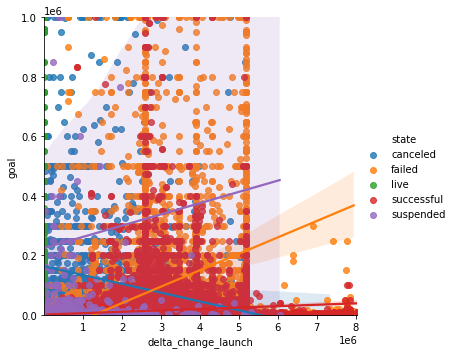

In [114]:
plt.figure(figsize=(15,10))
sns.lmplot(data=df, x='delta_change_launch', y='goal', hue='state')
plt.ylim(0,1e6);

<Figure size 1080x720 with 0 Axes>

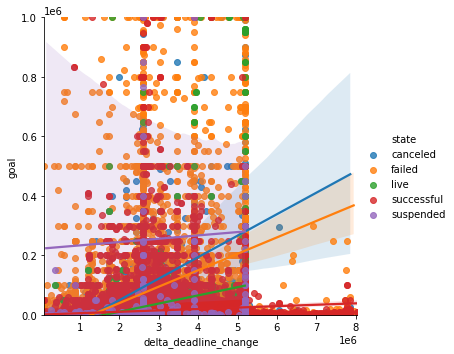

In [115]:
plt.figure(figsize=(15,10))
sns.lmplot(data=df, x='delta_deadline_change', y='goal', hue='state')
plt.ylim(0,1e6);

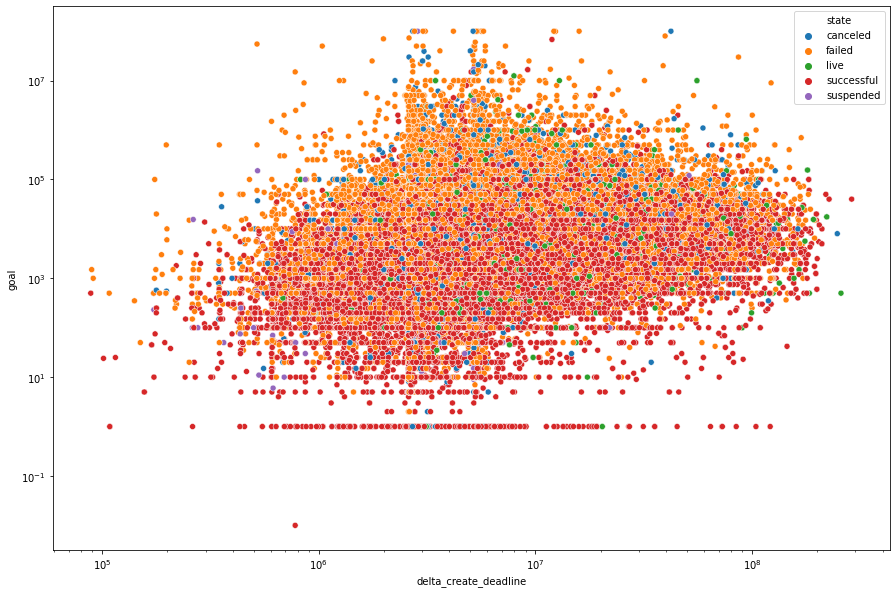

In [128]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_create_deadline', y='goal', hue='state')
plt.yscale('log')
plt.xscale('log')

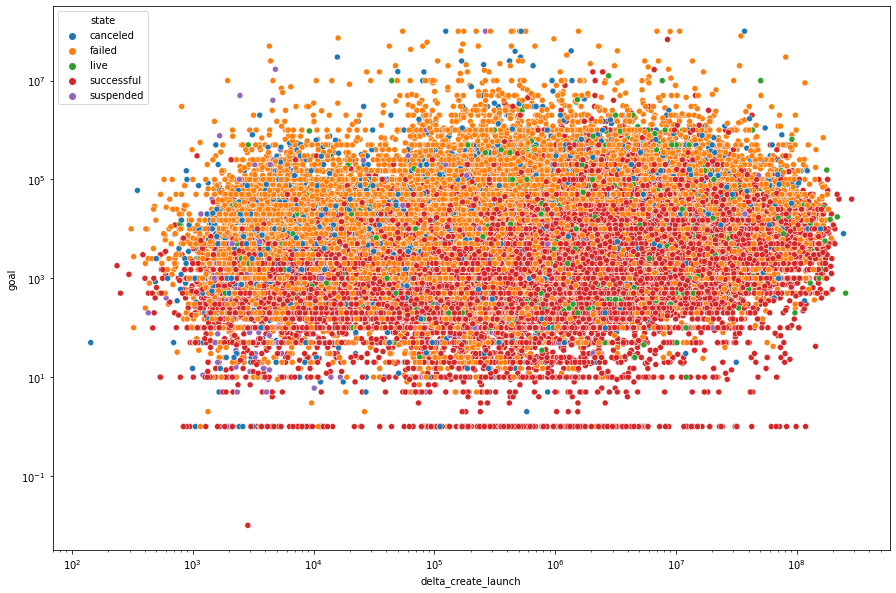

In [129]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_create_launch', y='goal', hue='state')
plt.yscale('log')
plt.xscale('log')

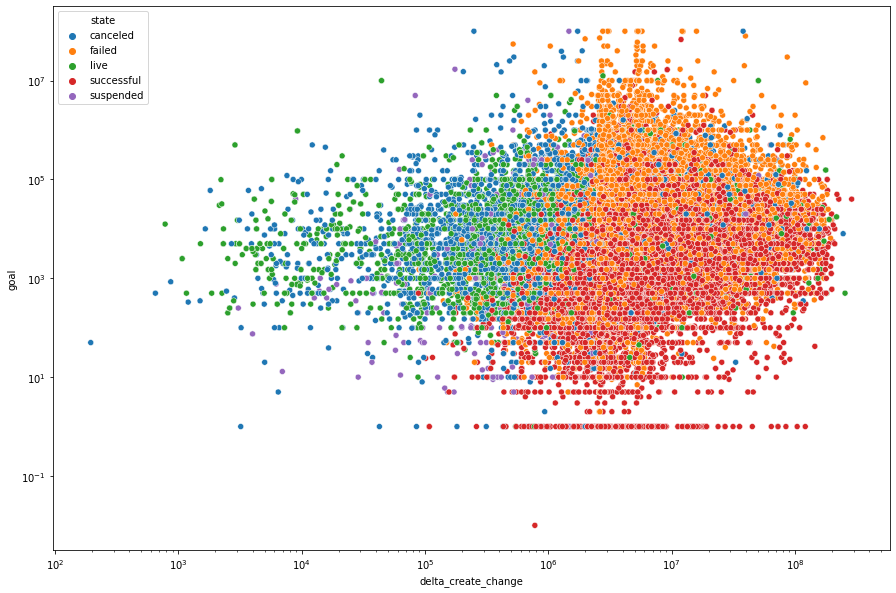

In [130]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_create_change', y='goal', hue='state')
plt.yscale('log')
plt.xscale('log')

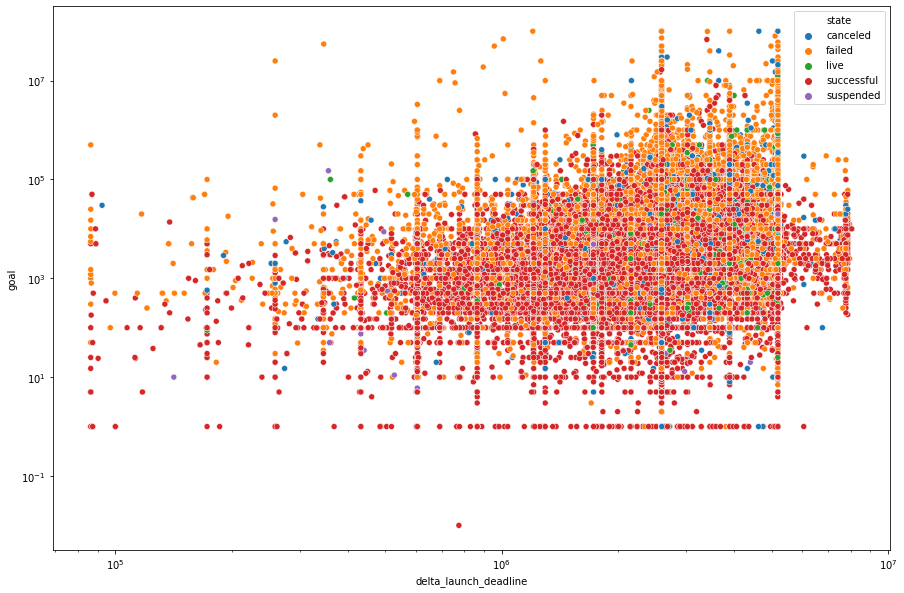

In [131]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_launch_deadline', y='goal', hue='state')
plt.yscale('log')
plt.xscale('log')

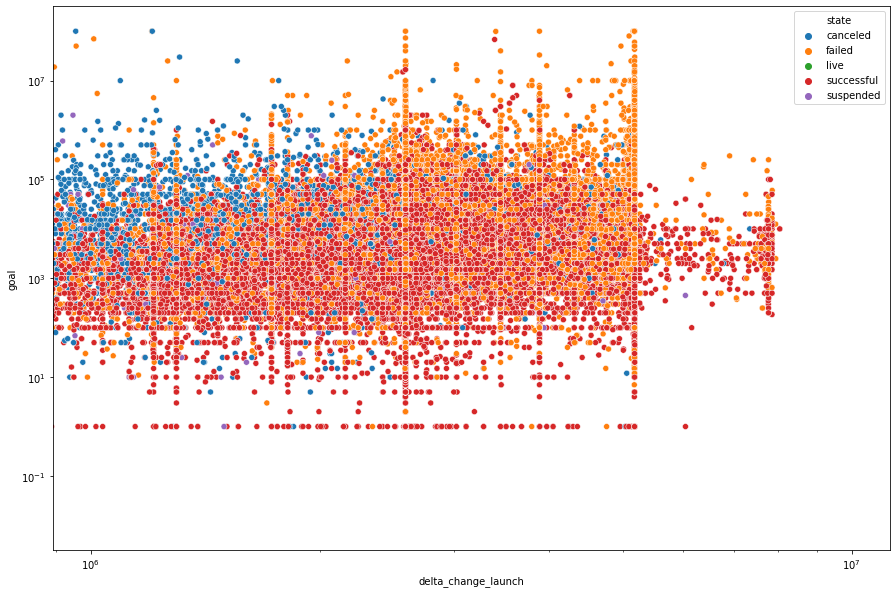

In [132]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_change_launch', y='goal', hue='state')
plt.yscale('log')
plt.xscale('log')

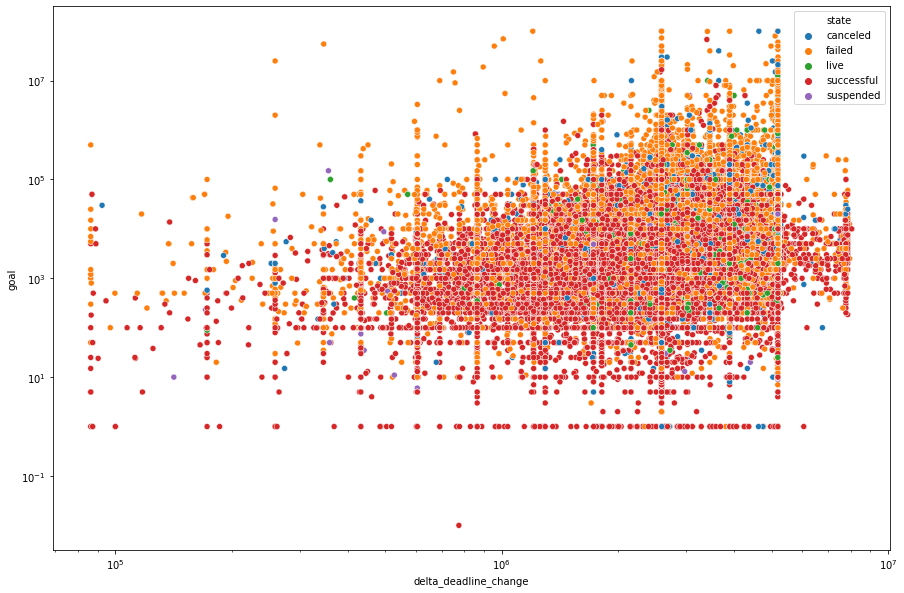

In [137]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_deadline_change', y='goal', hue='state')
plt.yscale('log')
plt.xscale('log')

In [152]:
M = pd.crosstab(df.delta_change_launch, df.is_starrable)
M

is_starrable         False  True 
delta_change_launch              
0                      239   3179
1                      176   2523
2                        0     47
3                        0      8
4                        0      4
...                    ...    ...
7862403                  1      0
7862407                  1      0
7945200                  1      0
7948800                  1      0
8044324                  2      0

[54022 rows x 2 columns]

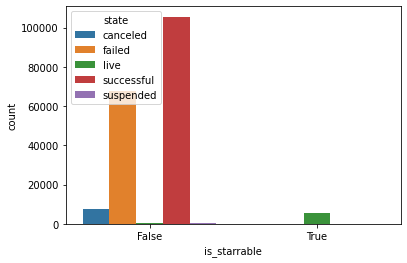

In [156]:
sns.countplot(x=df.is_starrable, hue=df.state);

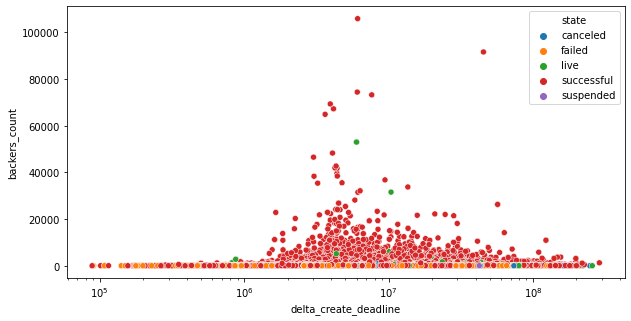

In [162]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_create_deadline', y='backers_count', hue='state')
#plt.yscale('log')
plt.xscale('log')

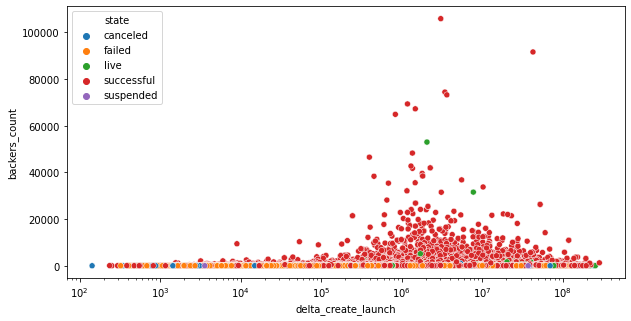

In [176]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_create_launch', y='backers_count', hue='state')
#plt.yscale('log')
plt.xscale('log')

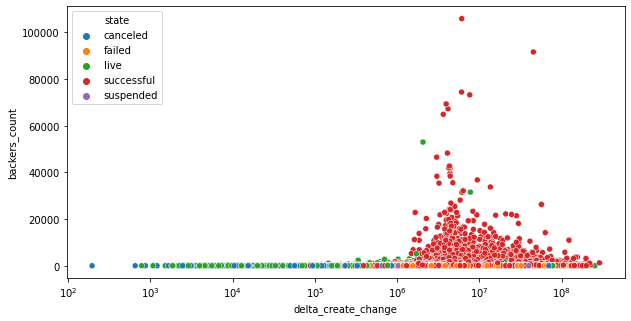

In [174]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_create_change', y='backers_count', hue='state')
#plt.yscale('log')
plt.xscale('symlog')

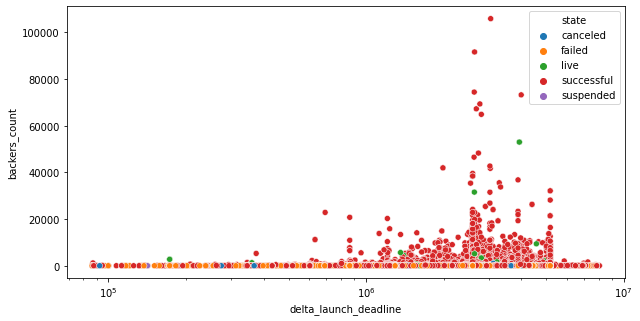

In [173]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_launch_deadline', y='backers_count', hue='state')
#plt.yscale('log')
plt.xscale('log')

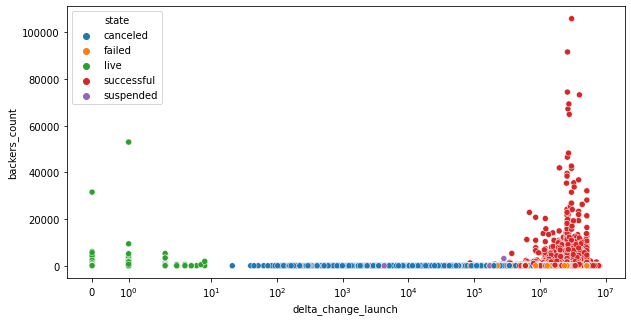

In [171]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_change_launch', y='backers_count', hue='state')
#plt.yscale('log')
plt.xscale('symlog')

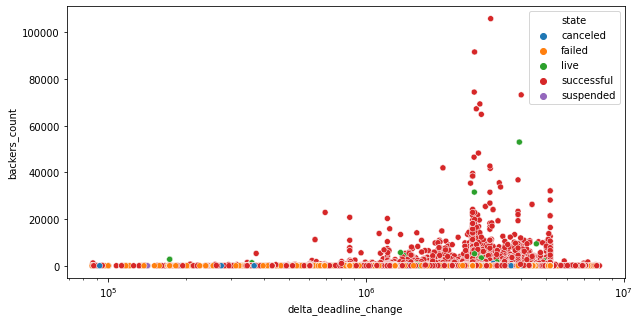

In [179]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_deadline_change', y='backers_count', hue='state')
#plt.yscale('log')
plt.xscale('log')

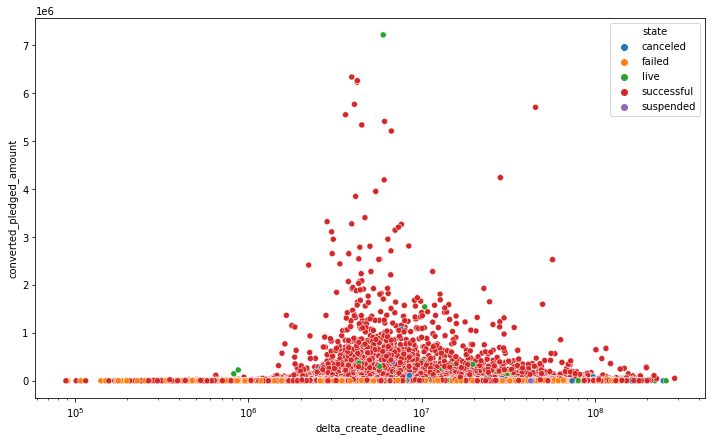

In [182]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_create_deadline', y='converted_pledged_amount', hue='state')
#plt.yscale('log')
plt.xscale('log')

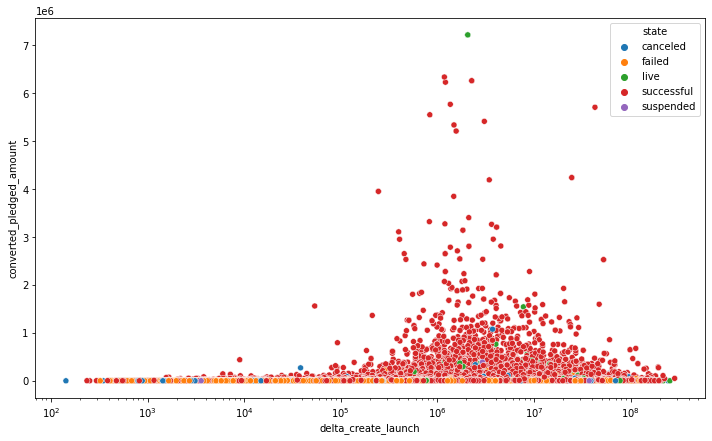

In [185]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_create_launch', y='converted_pledged_amount', hue='state')
#plt.yscale('log')
plt.xscale('log')

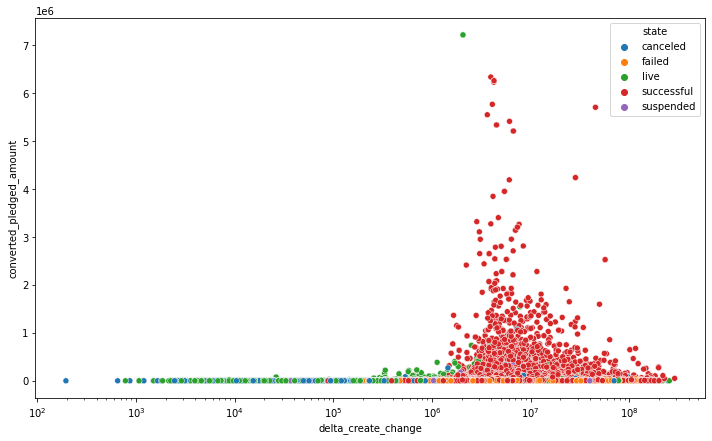

In [188]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_create_change', y='converted_pledged_amount', hue='state')
#plt.yscale('log')
plt.xscale('log')

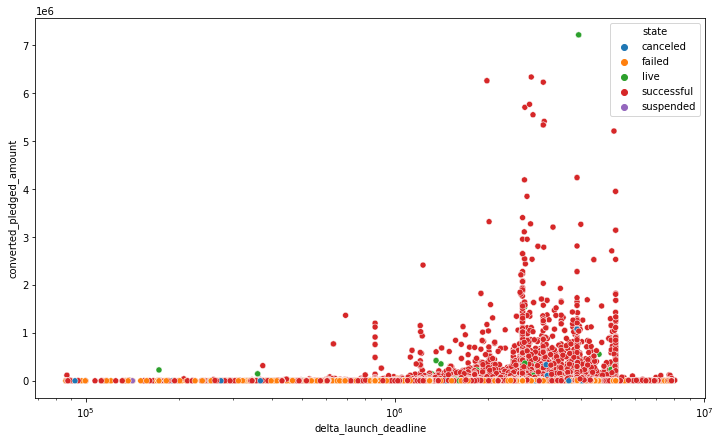

In [189]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_launch_deadline', y='converted_pledged_amount', hue='state')
#plt.yscale('log')
plt.xscale('log')

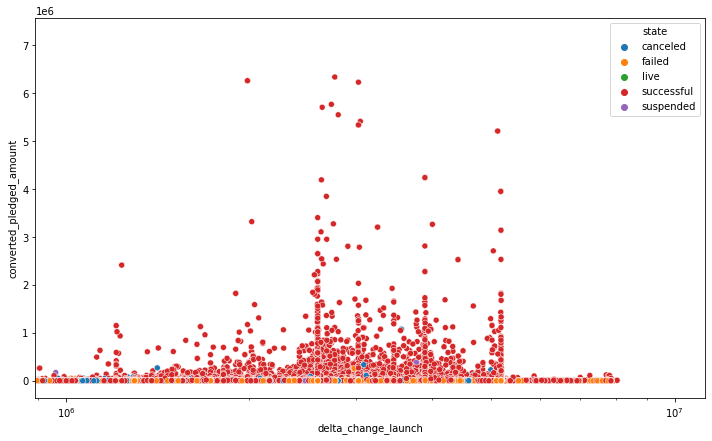

In [190]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_change_launch', y='converted_pledged_amount', hue='state')
#plt.yscale('log')
plt.xscale('log')

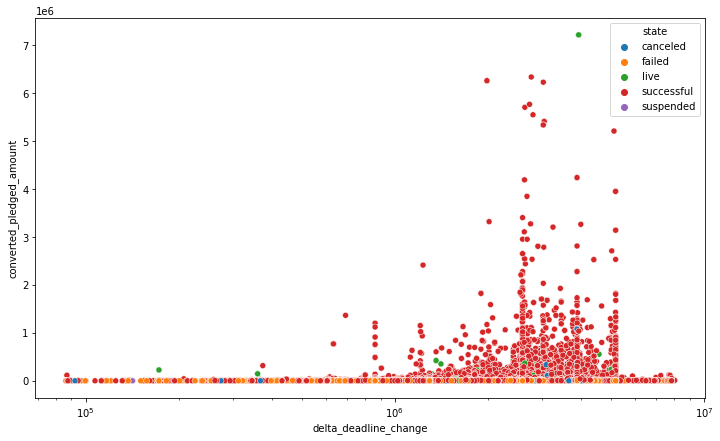

In [193]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_deadline_change', y='converted_pledged_amount', hue='state')
#plt.yscale('log')
plt.xscale('log')

In [32]:
df_m = pd.read_csv('data/df_clean.csv')
df_m.drop(df_m.columns[df_m.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [33]:
df_m = prepForModel(df_m)

In [34]:
from datetime import datetime
def timeline(t, m='dt'):
    if m == 'days':
        return int(t/24/60/60)
    elif m == 'months':
        return int(t/24/60/60/30.4167)
    elif m == 'year':
        return int(t/24/60/60/30.4167/12) + 1970
    elif m == 'dt':
        return datetime.fromtimestamp(t)

In [37]:
for i in range(len(df_m.created_at)):
    a = datetime.fromtimestamp(df_m.created_at[i])
    df_m.created_at[i]=a.month
for i in range(len(df_m.launched_at)):
    a = datetime.fromtimestamp(df_m.launched_at[i])
    df_m.launched_at[i]=a.month
for i in range(len(df_m.state_changed_at)):
    a = datetime.fromtimestamp(df_m.state_changed_at[i])
    df_m.state_changed_at[i]=a.month
for i in range(len(df_m.deadline)):
    a = datetime.fromtimestamp(df_m.deadline[i])
    df_m.deadline[i]=a.month

<ipython-input-37-eb24313506a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m.created_at[i]=a.month
<ipython-input-37-eb24313506a6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m.launched_at[i]=a.month
<ipython-input-37-eb24313506a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m.state_changed_at[i]=a.month
<ipython-input-37-eb24313506a6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [38]:
df_m.head()

backers_count  converted_pledged_amount country  created_at  deadline  \
0              2                         2      CA          10        11   
1              2                         2      US           5         8   
2            119                      5635      US           1         2   
3             70                      1317      US           1         3   
4             73                      5134      US           3         5   

   disable_communication     goal  is_starrable  launched_at  pledged  \
0                  False  30000.0         False           10     3.29   
1                  False  70000.0         False            7     2.00   
2                  False   4000.0         False            2  5635.00   
3                  False    500.0         False            2  1317.69   
4                  False   5000.0         False            4  5134.01   

   staff_pick       state  state_changed_at  usd_pledged   category_name  \
0       False      failed                11     2.513164             Web   
1       False      failed                 8     2.000000           Drama   
2       False  successful                 2  5635.000000     Restaurants   
3       False  successful                 3  1317.690000  Graphic Design   
4       False  successful                 5  5134.010000          Poetry   

           category_slug cgrouped  
0         journalism/web       CA  
1     film & video/drama       US  
2       food/restaurants       US  
3  design/graphic design       US  
4      publishing/poetry       US

In [84]:
M = pd.crosstab(df_m.created_at, df_m.state)
M

state       canceled  failed  live  successful  suspended
created_at                                               
1                662    5791  1543        9819         58
2                667    5347  2591        8525         48
3                647    5571   735        9586         61
4                601    5527    45        8924         33
5                610    5727    22        9241         38
6                596    5623    36        8347         41
7                839    7367    82        9069         58
8                735    5950    85        9217         47
9                630    5467   143        9010         41
10               685    5680   235        9382         39
11               633    5390   262        8153         61
12               442    4193   405        6262         36

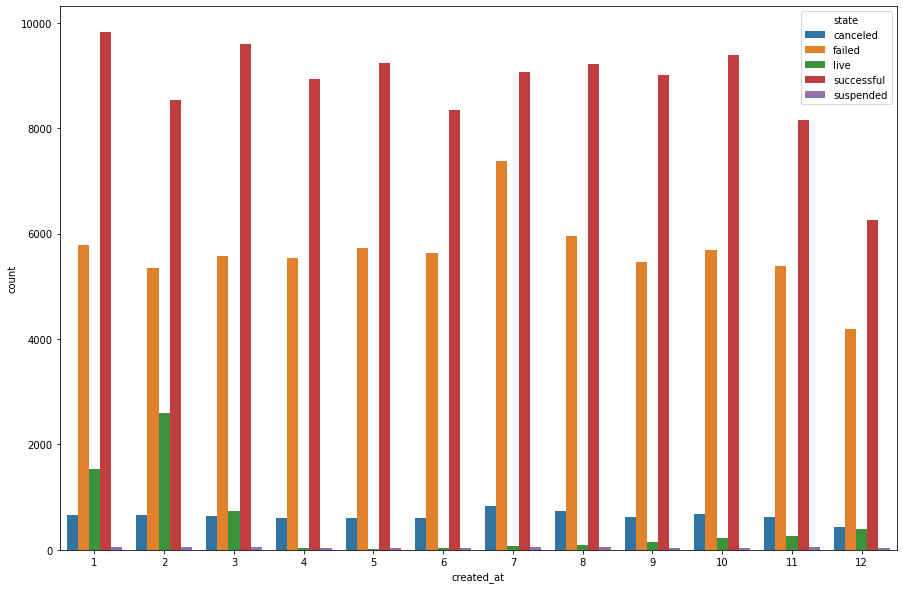

In [93]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_m.created_at, hue=df_m.state);

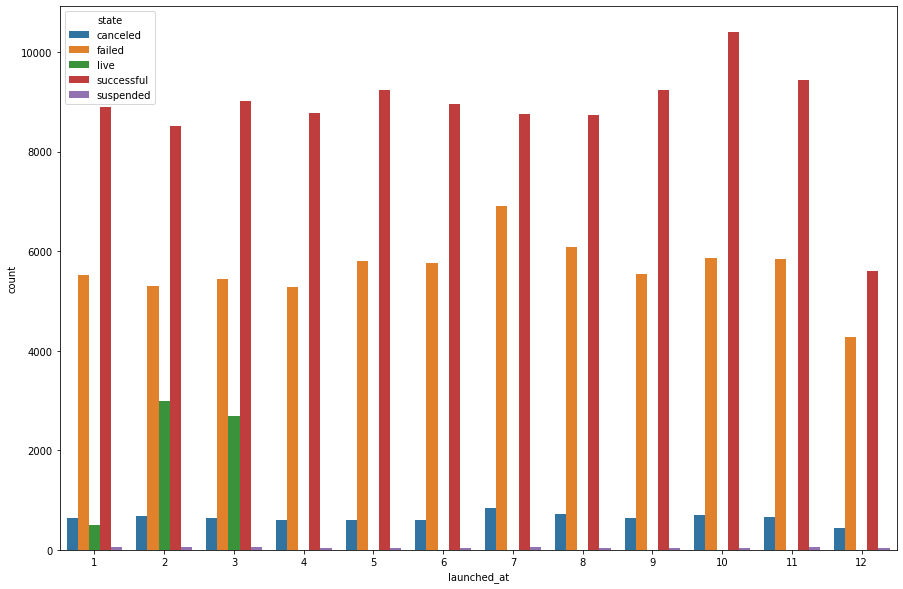

In [94]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_m.launched_at, hue=df_m.state);

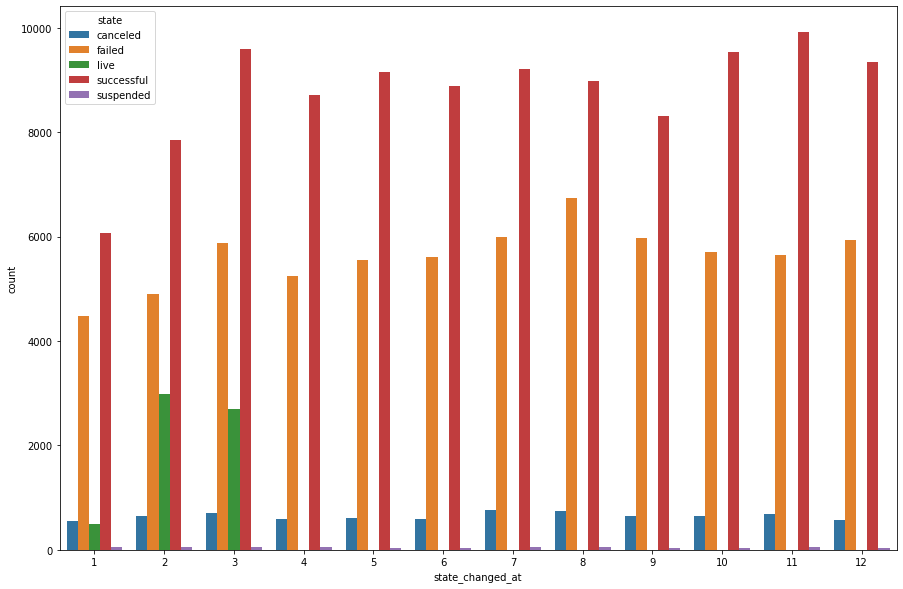

In [95]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_m.state_changed_at, hue=df_m.state);

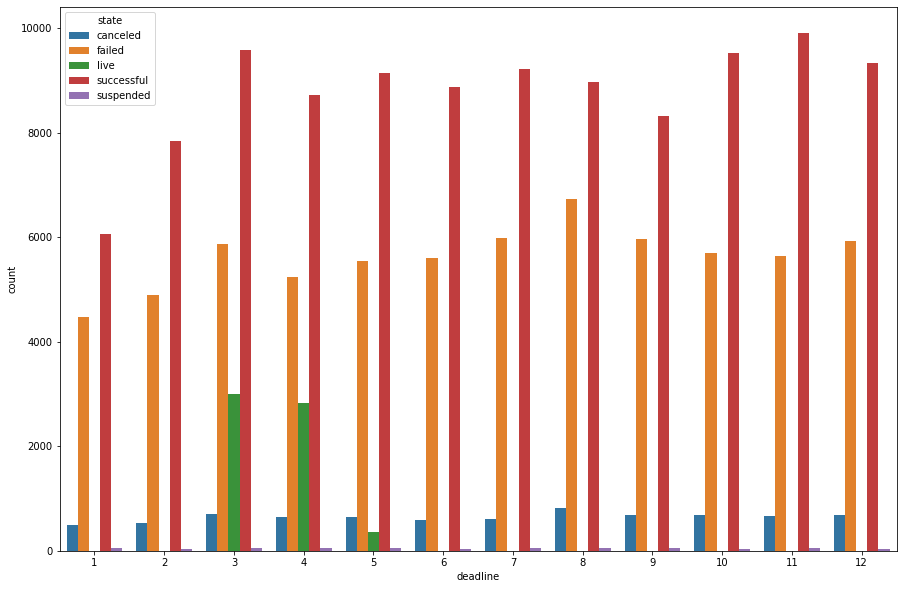

In [96]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_m.deadline, hue=df_m.state);

In [272]:
df_y = pd.read_csv('data/df_clean.csv')
df_y.drop(df_y.columns[df_y.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_y = prepForModel(df_y)

from datetime import datetime
def timeline(t, m='dt'):
    if m == 'days':
        return int(t/24/60/60)
    elif m == 'months':
        return int(t/24/60/60/30.4167)
    elif m == 'year':
        return int(t/24/60/60/30.4167/12) + 1970
    elif m == 'dt':
        return datetime.fromtimestamp(t)

for i in range(len(df_y.created_at)):
    a = datetime.fromtimestamp(df_y.created_at[i])
    df_y.created_at[i]=a.year
for i in range(len(df_y.launched_at)):
    a = datetime.fromtimestamp(df_y.launched_at[i])
    df_y.launched_at[i]=a.year
for i in range(len(df_y.state_changed_at)):
    a = datetime.fromtimestamp(df_y.state_changed_at[i])
    df_y.state_changed_at[i]=a.year
for i in range(len(df_y.deadline)):
    a = datetime.fromtimestamp(df_y.deadline[i])
    df_y.deadline[i]=a.year

<ipython-input-272-422bed200091>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.created_at[i]=a.year
<ipython-input-272-422bed200091>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.launched_at[i]=a.year
<ipython-input-272-422bed200091>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.state_changed_at[i]=a.year
<ipython-input-272-422bed200091>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [273]:
Year = pd.crosstab(df_y.created_at, df_y.state)
Year

state       canceled  failed  live  successful  suspended
created_at                                               
2009               7      33     0         136          0
2010              41     263     0         919          0
2011             128     845     1        3158          4
2012             177    1970     2        6818          3
2013             246    2426    10        8529          1
2014            1537   11984     9       13515         89
2015            2021   17391    15       14994        259
2016            1459   12440    34       13232         80
2017            1141   11491    72       15798         66
2018             896    8390  1249       26419         55
2019              94     400  4792        2017          4

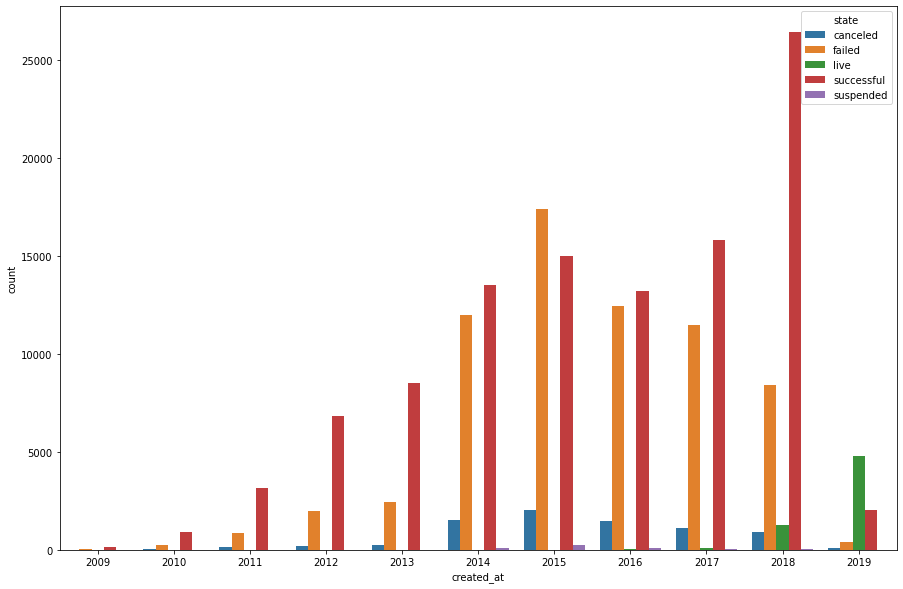

In [274]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_y.created_at, hue=df_y.state);

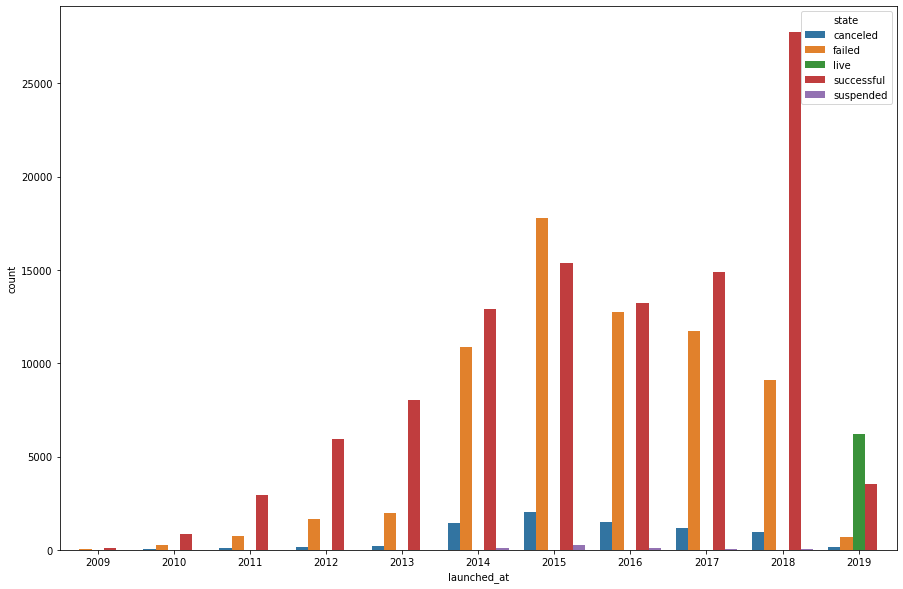

In [275]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_y.launched_at, hue=df_y.state);

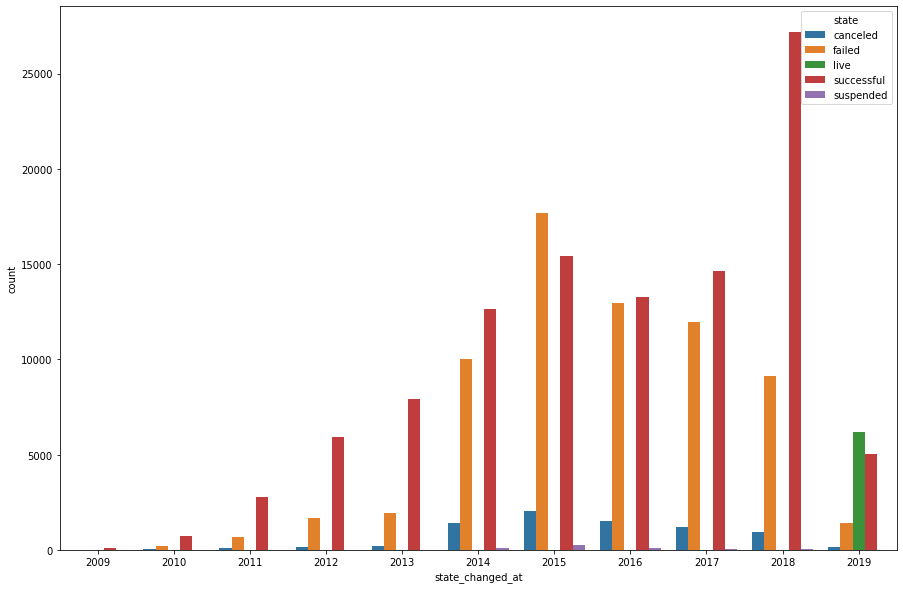

In [276]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_y.state_changed_at, hue=df_y.state);

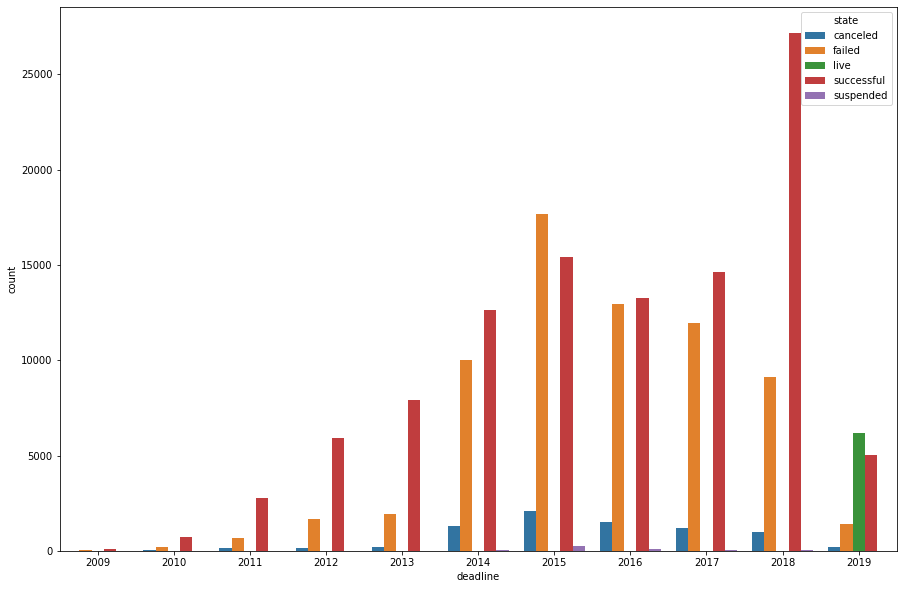

In [277]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_y.deadline, hue=df_y.state);

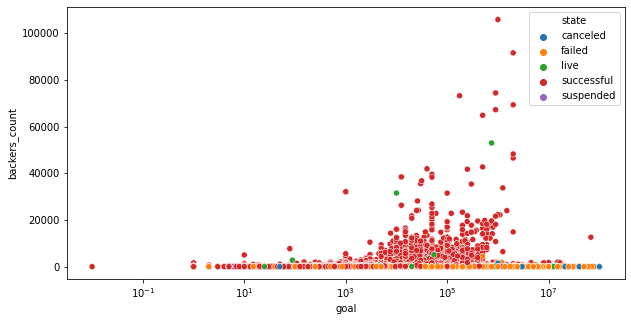

In [200]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='goal', y='backers_count', hue='state')
#plt.yscale('log')
plt.xscale('log')

#### feature engineering

* drop outliers:

In [ ]:
#Dropping the outlier rows with standard deviation
factor = 3
upper_lim = data['column'].mean () + data['column'].std () * factor
lower_lim = data['column'].mean () - data['column'].std () * factor

data = data[(data['column'] < upper_lim) & (data['column'] > lower_lim)

In [ ]:
#Dropping the outlier rows with Percentiles
upper_lim = data['column'].quantile(.95)
lower_lim = data['column'].quantile(.05)

data = data[(data['column'] < upper_lim) & (data['column'] > lower_lim)]

* log transformation on
  - goal
  - timestamp deltas
  - other skewed data from pandas profiling

In [264]:
a = df.goal
len(a)

187660

In [267]:
upper_lim = a.quantile(.95)
#lower_lim = a.quantile(.05)

b = df[(df['goal'] < upper_lim) & (df['goal'] > 0)]

In [268]:
len(b)

178168

In [269]:
len(b)/len(a)

0.9494191623148247

/Users/juliusjenek/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='goal'>

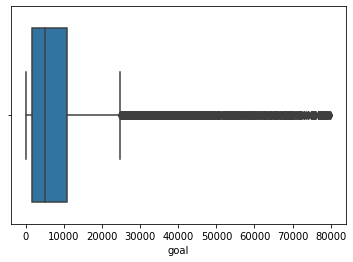

In [271]:
sns.boxplot(b.goal)